In [1]:
# want to store this notebook in the notebooks folder, but want to keep non-relative imports
import os
os.chdir("..")

In [2]:
import sys
import time
import copy

from itertools import repeat
import data, data.gene_datasets
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import gene_inference
#from gene_inference.infer_genes import infer_all_genes, sample_neighbors
import models, models.graphLayer
from models.models import CGN
import data, data.gene_datasets
from data.graph import Graph
from data.utils import split_dataset
import optimization
import torch
from torch.autograd import Variable
from analysis.metrics import record_metrics_for_epoch
import analysis
reload(analysis.metrics)
reload(gene_inference);

/u/weissmar/venv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#tcgatissue = data.gene_datasets.TCGATissue(data_dir='./genomics/TCGA/', data_file='TCGA_tissue_ppi.hdf5')
tcgatissue = data.gene_datasets.TCGATissue()

Converting one-hot labels to integers


In [4]:
tcgatissue.data.shape

(10459, 16300)

In [5]:
class Object(object):
    pass

opt = Object()
opt.seed = 0
opt.nb_class = None
opt.nb_examples = None
opt.nb_nodes = None
opt.graph = "pathway"
opt.dataset = tcgatissue
opt.add_self = True
opt.norm_adj = True
opt.add_connectivity = False
opt.num_layer = 1
opt.cuda = True
opt.pool_graph = "ignore"


In [6]:
graph = Graph()
path = "/data/lisa/data/genomics/graph/pancan-tissue-graph.hdf5"
graph.load_graph(path)
#graph.intersection_with(tcgatissue)
g = nx.from_numpy_matrix(graph.adj)
mapping = dict(zip(range(0, len(tcgatissue.df.columns)), tcgatissue.df.columns))
g = nx.relabel_nodes(g, mapping)

In [6]:
#load random
#graph.load_random_adjacency(tcgatissue.nb_nodes, (graph.adj != 0).sum(), scale_free=False)
# g = nx.from_numpy_matrix(graph.adj)
# mapping = dict(zip(range(0, len(tcgatissue.df.columns)), tcgatissue.df.columns))
# g = nx.relabel_nodes(g, mapping)

In [7]:
def sample_neighbors(g, gene, num_neighbors, include_self=True):
    results = set([])
    if include_self:
        results = set([gene])
    all_nodes = set(g.nodes)
    first_degree = set(g.neighbors(gene))
    second_degree = set()
    for x in g.neighbors(gene):
        second_degree = second_degree.union(set(g.neighbors(x)))
    while len(results) < num_neighbors:
        if len(first_degree) - len(results) > 0:
            unique = sorted(first_degree - results)
            results.add(unique.pop())
        elif len(second_degree) - len(results) > 0:
            unique = sorted(second_degree - results)
            results.add(unique.pop())
        else:
            unique = sorted(all_nodes - results)
            results.add(unique.pop())
    return results

In [8]:
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np

class Method:
    def __init__(self):
        pass

class SkLearn(Method):
    
    def __init__(self, model, penalty=False):
        self.model = model
        self.penalty = penalty
        
    def loop(self, dataset, seed, train_size, test_size, adj=None):
        
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)

        if self.model == "LR":
            model = sklearn.linear_model.LogisticRegression()
            if self.penalty:
                model = sklearn.linear_model.LogisticRegression(penalty='l1', tol=0.0001)
        elif self.model == "DT":
            model = sklearn.tree.DecisionTreeClassifier()
        elif self.model == "MLP":
            model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(32,3), learning_rate_init=0.001, early_stopping=False,  max_iter=1000)
        else:
            print "incorrect label"
        
        model = model.fit(X_train, y_train)
        return sklearn.metrics.roc_auc_score(y_test, model.predict(X_test))


class PyTorch(Method):    
    
    def __init__(self, model, num_epochs=100, num_channel=64, num_layer=3, add_emb=32, use_gate=False, dropout=True, cuda=True, attention_head=0, l1_loss_lambda=0, model_reg_lambda=0, training_mode=None, pool=False, prepool_extralayers=0):
        self.model = model
        self.batch_size = 10
        self.num_channel = num_channel
        self.num_layer = num_layer
        self.add_emb = add_emb
        self.use_gate = use_gate
        self.dropout = dropout
        self.cuda = cuda
        self.num_epochs = num_epochs
        self.patience = 10
        self.attention_head = attention_head
        self.l1_loss_lambda = l1_loss_lambda
        self.model_reg_lambda = model_reg_lambda
        self.training_mode = training_mode
        self.pool = pool
        self.prepool_extralayers = prepool_extralayers
        
    def loop(self, dataset, seed, train_size, test_size, adj=None):
    
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size*2, test_size=test_size, random_state=seed)
    
        #split train into valid and train
        local_X_train, local_X_valid, local_y_train, local_y_valid = sklearn.model_selection.train_test_split(X_train, y_train, stratify=y_train, train_size=0.50, random_state=seed)
        local_X_train = torch.FloatTensor(np.expand_dims(local_X_train, axis=2))
        local_X_valid = torch.FloatTensor(np.expand_dims(local_X_valid, axis=2))
        X_test = torch.FloatTensor(np.expand_dims(X_test, axis=2))
        
        local_y_train = torch.FloatTensor(local_y_train)

        criterion = optimization.get_criterion(dataset)
        patience = self.patience
        opt.num_layer = self.num_layer
        
        if self.model == "CGN":
            opt2 = copy.copy(opt)
            if self.pool:
                opt2.pool_graph = "hierarchy"
            else:
                opt2.pool_graph = "ignore"
            adj_transform, aggregate_function = models.graphLayer.get_transform(opt2, adj)
            model = models.models.CGN(
                    nb_nodes=len(dataset.df.columns), 
                    input_dim=1,
                    channels=[self.num_channel] * self.num_layer,
                    adj=adj,
                    out_dim=2,
                    on_cuda=self.cuda,
                    add_emb=self.add_emb,
                    transform_adj=adj_transform,
                    aggregate_adj=aggregate_function,
                    use_gate=self.use_gate,
                    dropout=self.dropout,
                    attention_head=self.attention_head, 
                    prepool_extralayers=self.prepool_extralayers
                    )
        elif self.model == "MLP":
            model = models.models.MLP(
                    len(dataset.df.columns), 
                    channels=[self.num_channel] * self.num_layer, 
                    out_dim=2, 
                    on_cuda=self.cuda, 
                    dropout=self.dropout)
        elif self.model == "SLR":
            model = models.models.SparseLogisticRegression(
                    nb_nodes=len(dataset.df.columns), 
                    input_dim=1, 
                    adj=adj, 
                    out_dim=2, 
                    on_cuda=self.cuda)
        elif self.model == "LCG":
            opt2 = copy.copy(opt)
            if self.pool:
                opt2.pool_graph = "hierarchy"
            else:
                opt2.pool_graph = "ignore"
            adj_transform, aggregate_function = models.graphLayer.get_transform(opt2, adj)
            model = models.models.LCG(
                    nb_nodes=len(dataset.df.columns), 
                    input_dim=1, 
                    channels=[self.num_channel] * self.num_layer,
                    adj=adj, 
                    out_dim=2,
                    on_cuda=self.cuda,
                    add_emb=self.add_emb,
                    transform_adj=adj_transform, 
                    aggregate_adj=aggregate_function, 
                    use_gate=self.use_gate,
                    dropout=self.dropout,
                    attention_head=nb_attention_head, 
                    training_mode=training_mode)
            
            
            
        if self.cuda:
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
            model.cuda()

        l1_criterion = torch.nn.L1Loss(size_average=False)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
        max_valid = 0
        max_valid_test = 0
        for t in range(0, self.num_epochs):
            start_timer = time.time()
            
            for base_x in range(0,local_X_train.shape[0], self.batch_size):
                inputs, labels = local_X_train[base_x:base_x+self.batch_size], local_y_train[base_x:base_x+self.batch_size]

                inputs = Variable(inputs, requires_grad=False).float()
                if self.cuda:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                model.train()
                y_pred = model(inputs)

                
                # Compute and print loss
                crit_loss = optimization.compute_loss(criterion, y_pred, labels, self.training_mode)
                model_regularization_loss = model.regularization(self.model_reg_lambda)
                l1_loss = models.models.setup_l1_loss(model, self.l1_loss_lambda, l1_criterion, opt.cuda)
                total_loss = crit_loss + model_regularization_loss + l1_loss
                

                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad()
                crit_loss.backward()
                optimizer.step()
                model.eval()

            auc = {}
            res = []
            for base_x in range(0,local_X_train.shape[0], self.batch_size):
                inputs = Variable(local_X_train[base_x:base_x+self.batch_size], requires_grad=False).float()
                res.append(model(inputs.cuda())[:,1].data.cpu().numpy())
            auc['train'] = sklearn.metrics.roc_auc_score(local_y_train.numpy(), np.asarray(res).flatten())
            
            res = []
            for base_x in range(0,local_X_valid.shape[0], self.batch_size):
                inputs = Variable(local_X_valid[base_x:base_x+self.batch_size], requires_grad=False).float()
                res.append(model(inputs.cuda())[:,1].data.cpu().numpy())
            auc['valid'] = sklearn.metrics.roc_auc_score(local_y_valid, np.asarray(res).flatten())
            
            res = []
            for base_x in range(0,X_test.shape[0], self.batch_size):
                inputs = Variable(X_test[base_x:base_x+self.batch_size], requires_grad=False).float()
                res.append(model(inputs.cuda())[:,1].data.cpu().numpy())
            auc['test'] = sklearn.metrics.roc_auc_score(y_test, np.asarray(res).flatten())
            
            
            time_this_epoch = time.time() - start_timer

#eval on cpu
#             auc['train'] = sklearn.metrics.roc_auc_score(local_y_train.numpy(), model(Variable(local_X_train.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
#             auc['valid'] = sklearn.metrics.roc_auc_score(local_y_valid, model(Variable(local_X_valid.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
#             auc['test'] = sklearn.metrics.roc_auc_score(y_test, model(Variable(X_test.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
            
            summary = [ t, crit_loss.data[0], auc['train'], auc['valid'], time_this_epoch ]
            summary = "epoch {}, cross_loss: {:.03f}, auc_train: {:0.3f}, auc_valid:{:0.3f}, time: {:.02f} sec".format(*summary)
            #print summary

            patience = patience - 1
            if patience == 0:
                return max_valid_test
                break
            if (max_valid < auc['valid']) and t > 5:
                max_valid = auc['valid']
                max_valid_test = auc['test']
                patience = self.patience

In [9]:
#             model = models.models.MLP(
#                     20, 
#                     channels=[32] * 1,
#                     out_dim=2, 
#                     on_cuda=True, 
#                     dropout=False)

In [10]:
# adj_transform, aggregate_function = models.graphLayer.get_transform(opt, nx.to_numpy_matrix(g))
# model = models.models.CGN(
#                     nb_nodes=len(tcgatissue.df.columns), 
#                     input_dim=1,
#                     channels=[32] * 3,
#                     adj=nx.to_numpy_matrix(g),
#                     out_dim=2,
#                     on_cuda=True,
#                     add_emb=False,
#                 transform_adj=adj_transform,
#                     aggregate_adj=aggregate_function,
#                     )

In [11]:
# tcgatissue.data[:10,:20].shape

In [12]:
# torch.FloatTensor(tcgatissue.data[:10,:20])[0].view(1,-1)

In [13]:
# res = [model(Variable(x.view(1,1,-1), requires_grad=False)).cpu().data.numpy()[0][1] for x in torch.FloatTensor(tcgatissue.data[:10,:20])]


In [14]:
# res

In [15]:
#model(Variable(tcgatissue.data, requires_grad=False).float())

In [16]:
#             model = models.models.CGN(
#                     nb_nodes=len(tcgatissue.df.columns), 
#                     input_dim=1,
#                     channels=[32] * 3,
#                     adj=nx.to_numpy_matrix(g),
#                     out_dim=2,
#                     on_cuda=True,
#                     add_emb=False,
#                 transform_adj=None,
#                     aggregate_adj=None,
#                     )
# model(Variable(local_X_train, requires_grad=False).float())

In [9]:
def method_comparison(results, dataset, models, gene, search_num_genes, trials, search_train_size, test_size):
    
    dataset = data.gene_datasets.TCGATissue()
    dataset.df = dataset.df - dataset.df.mean()
    
    mean = dataset.df[gene].mean()
    dataset.labels = [1 if x > mean else 0 for x in dataset.df[gene]]
    full_df = dataset.df.copy(deep=True)
    
    for train_size in search_train_size:
        for ex in search_num_genes:

            num_genes = ex
            num_genes = np.min([num_genes, tcgatissue.df.shape[1]])
            print ex, num_genes

            neighbors = sample_neighbors(g, gene, num_genes, include_self=True)
            print "neighbors", len(neighbors), "train_size", train_size
            
            dataset.df = dataset.df[list(neighbors)]
            dataset.df[gene] = 1
            dataset.data = dataset.df.as_matrix()
            
            neighborhood = np.asarray(nx.to_numpy_matrix(nx.Graph(g.subgraph(neighbors))))
            for model in models:
                for seed in range(trials):

                    #have we already done it?
                    already_done = results["df"][(results["df"].gene_name == gene) & 
                                                 (results["df"].model == model['key']) &
                                                 (results["df"].num_genes == num_genes) &
                                                 (results["df"].seed == seed) &
                                                 (results["df"].train_size == train_size)].shape[0] > 0

                    if already_done:
                        print "already done:", model['key'], "num_genes", num_genes, "train_size", train_size, "seed", seed
                        continue
                    print "doing:", model['key'], "num_genes", num_genes, "train_size", train_size, "seed", seed

                    result = model['method'].loop(dataset=dataset, seed=seed, train_size=train_size, test_size=test_size, adj=neighborhood)

                    experiment = {"gene_name": gene,
                            "model": model['key'],
                            "num_genes": num_genes, 
                            "seed":seed,
                            "train_size": train_size,
                            "auc":result
                            }

                    results["df"] = results["df"].append(experiment, ignore_index=True)
                    pickle.dump(results, open("results_temp.pkl", "wb"))
            dataset.df = full_df
    

In [10]:
import pickle

m = [
#    {'key': 'LR-L1', 'method': SkLearn("LR", penalty=True)},
#    {'key': 'MLP', 'method': mlp},
#    {'key': 'DT', 'method': SkLearn("DT")},

#{'key': 'CGN_3_layer_64_channel_emb_32_dropout', 'method': PyTorch("CGN")},
# #    {'key': 'wRPL5_CGN_3_layer_64_channel_emb_32_dropout_attn3', 'method': PyTorch("CGN", attention_head=3)},
#  #{'key': 'wRPL5_CGN_1_layer_32_channel_emb_32_dropout', 'method': PyTorch("CGN", num_layer=1, num_channel=32)},
#     {'key': 'MLP-dropout', 'method': PyTorch("MLP", dropout=True)},
#     {'key': 'CGN_2_layer_512_channel_emb_32_dropout', 'method': PyTorch("CGN", num_layer=2, num_channel=512, add_emb=32)},
#     {'key': 'CGN_3_layer_512_channel_emb_32_dropout', 'method': PyTorch("CGN", num_layer=3, num_channel=512, add_emb=32)},
#     {'key': 'CGN_1_layer_768_channel_emb_32_dropout', 'method': PyTorch("CGN", num_layer=1, num_channel=768, add_emb=32)},
#     {'key': 'CGN_2_layer_512_channel_emb_128_dropout', 'method': PyTorch("CGN", num_layer=2, num_channel=512, add_emb=128)},
#     {'key': 'CGN_2_layer_512_channel_emb_256_dropout', 'method': PyTorch("CGN", num_layer=2, num_channel=512, add_emb=256)},
#    {'key': 'CGN_2_layer_512_channel_emb_512_dropout', 'method': PyTorch("CGN", num_layer=2, num_channel=512, add_emb=512)},

    #    {'key': 'MLP_2_chan128', 'method': PyTorch("MLP", dropout=False, num_layer=2, num_channel=128)},
#    {'key': 'MLP_2_chan256', 'method': PyTorch("MLP", dropout=False, num_layer=2, num_channel=256)},

#    {'key': 'MLP_2_chan1024', 'method': PyTorch("MLP", dropout=False, num_layer=2, num_channel=1024)},
#    {'key': 'MLP_2', 'method': PyTorch("MLP", dropout=False, num_layer=2)},
#    {'key': 'MLP_1', 'method': PyTorch("MLP", dropout=False, num_layer=1)},
#     {'key': 'MLP-dropout-l1-1', 'method': PyTorch("MLP", dropout=True, l1_loss_lambda=1)},
#     {'key': 'SLR2=lambda1', 'method': PyTorch("SLR", model_reg_lambda=1)},
#    {'key': 'SLR2=lambda100', 'method': PyTorch("SLR", model_reg_lambda=100)},

#   {'key': 'MLP', 'method': PyTorch("MLP", dropout=False)},
    
    
    
#       {'key': 'CGN_lay2_chan8_emb256_dropout_pool', 'method': PyTorch("CGN", num_layer=2,num_channel=8, add_emb=256, pool=True)},   
#       {'key': 'CGN_lay4_chan8_emb256_dropout_pool', 'method': PyTorch("CGN", num_layer=4,num_channel=8, add_emb=256, pool=True)},   
   #   {'key': 'CGN_lay8_chan64_emb32_dropout_pool', 'method': PyTorch("CGN", num_layer=4,num_channel=64, add_emb=32, pool=True, prepool_extralayers=1)},   
      {'key': 'CGN_lay8_chan64_emb512_dropout_pool', 'method': PyTorch("CGN", num_layer=4,num_channel=64, add_emb=512, pool=True, prepool_extralayers=1)},   

    #      {'key': 'CGN_lay8_chan32_emb512_dropout_pool_test', 'method': PyTorch("CGN", num_layer=4,num_channel=32, add_emb=512, pool=True, prepool_extralayers=2)},   

    
    #     {'key': 'CGN_lay3_chan64_emb32_dropout', 'method': PyTorch("CGN", num_layer=3,num_channel=64, add_emb=32 )},
#     {'key': 'MLP_lay2_chan512_dropout', 'method': PyTorch("MLP", dropout=True, num_layer=2, num_channel=512)},
#      {'key': 'MLP_lay2_chan512', 'method': PyTorch("MLP", dropout=False, num_layer=2, num_channel=512)},
#      {'key': 'SLR_lambda1_l11', 'method': PyTorch("SLR", model_reg_lambda=1, l1_loss_lambda=1)},
    ]

#'CGN_2_layer_512_channel_emb_512_dropout', "MLP_2_chan512", "SLR2=lambda10-l1-1"

In [19]:
#a = nx.to_numpy_array(g)

In [20]:
#a.tostring()

In [21]:
#hash(str(a))

In [22]:
#results = pickle.load(open("results_S100A8.pkl", "r"))

In [23]:
#results = {"df": pd.DataFrame(columns=['auc','gene_name', 'model', 'num_genes', 'seed', 'train_size'])}

In [24]:
import pickle
results = pickle.load(open("results_temp.pkl", "r"))

In [ ]:
#pickle.dump(results, open("results-temp.pkl", "wb"))

In [ ]:
#"S100A8
#RPL5
#RPS10

# a = method_comparison(results, tcgatissue, m, gene="RPS10", 
#                       search_num_genes=[100], trials=10, 
#                       search_train_size=[50, 100, 200, 500, 1000, 2000, 4000, 8000], test_size=1000)


#a = method_comparison(results, tcgatissue, m, gene="S100A8", search_num_genes=[50, 100,200,300,400,500, 1000, 2000, 4000, 8000, 16000], trials=20, search_train_size=[50], test_size=1000)

a = method_comparison(results, tcgatissue, m, gene="S100A8", 
                      search_num_genes=[50, 100,200,300,400,500, 1000], #,4000, 8000, 16000], 
                      trials=10, search_train_size=[50], test_size=1000)


#a = method_comparison(results, tcgatissue, m, gene="RPS10", search_num_genes=[50, 100,200,300,400,500, 1000, 2000, 4000], trials=2, search_train_size=[50], test_size=1000)
#50, 100,200,300,400,

#[100,200,300,400,500, 1000, 2000, 4000, 8000, 16000]


Converting one-hot labels to integers
50 50
neighbors 50 train_size 50
already done: CGN_lay8_chan64_emb512_dropout_pool num_genes 50 train_size 50 seed 0
already done: CGN_lay8_chan64_emb512_dropout_pool num_genes 50 train_size 50 seed 1
already done: CGN_lay8_chan64_emb512_dropout_pool num_genes 50 train_size 50 seed 2
already done: CGN_lay8_chan64_emb512_dropout_pool num_genes 50 train_size 50 seed 3
already done: CGN_lay8_chan64_emb512_dropout_pool num_genes 50 train_size 50 seed 4
doing: CGN_lay8_chan64_emb512_dropout_pool num_genes 50 train_size 50 seed 5
add extra layer before pooling0
add extra layer before pooling0
add extra layer before pooling0
add extra layer before pooling0
Doing drop-out


/u/cohenjos/.local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/raid/Tmp/lisa/os_v5/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:193: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


doing: CGN_lay8_chan64_emb512_dropout_pool num_genes 50 train_size 50 seed 6
add extra layer before pooling0
add extra layer before pooling0
add extra layer before pooling0
add extra layer before pooling0
Doing drop-out
doing: CGN_lay8_chan64_emb512_dropout_pool num_genes 50 train_size 50 seed 7
add extra layer before pooling0
add extra layer before pooling0
add extra layer before pooling0
add extra layer before pooling0
Doing drop-out
doing: CGN_lay8_chan64_emb512_dropout_pool num_genes 50 train_size 50 seed 8
add extra layer before pooling0
add extra layer before pooling0
add extra layer before pooling0
add extra layer before pooling0
Doing drop-out
doing: CGN_lay8_chan64_emb512_dropout_pool num_genes 50 train_size 50 seed 9
add extra layer before pooling0
add extra layer before pooling0
add extra layer before pooling0
add extra layer before pooling0
Doing drop-out
100 100
neighbors 100 train_size 50
already done: CGN_lay8_chan64_emb512_dropout_pool num_genes 100 train_size 50 seed 0

/raid/Tmp/lisa/os_v5/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 100 train_size 50 seed 2
already done: CGN_lay8_chan64_emb512_dropout_pool num_genes 100 train_size 50 seed 3
already done: CGN_lay8_chan64_emb512_dropout_pool num_genes 100 train_size 50 seed 4
doing: CGN_lay8_chan64_emb512_dropout_pool num_genes 100 train_size 50 seed 5
add extra layer before pooling0
add extra layer before pooling0
add extra layer before pooling0
add extra layer before pooling0
Doing drop-out
doing: CGN_lay8_chan64_emb512_dropout_pool num_genes 100 train_size 50 seed 6
add extra layer before pooling0
add extra layer before pooling0
add extra layer before pooling0
add extra layer before pooling0
Doing drop-out
doing: CGN_lay8_chan64_emb512_dropout_pool num_genes 100 train_size 50 seed 7
add extra layer before pooling0
add extra layer before pooling0
add extra layer before pooling0
add extra layer before pooling0
Doing drop-out
doing: CGN_lay8_chan64_emb512_dropout_pool num_genes 100 train_size 50 seed 8
add extra layer before pooling0
add extra layer before pooling0

In [12]:
# plt.rcParams['figure.figsize'] = (10, 10)

# pos = nx.circular_layout(a)
# nx.draw_networkx(a,pos,with_labels=True, width=2)

In [119]:
results["df"]

,auc,gene_name,model,num_genes,seed,train_size


In [45]:
#results["df"] = results["df"].replace("wRPL5_CGN_3_layer_64_channel_emb_32_dropout", "CGN_3_layer_64_channel_emb_32_dropout")

In [39]:
#pickle.dump(results, open("results-temp.pkl", "wb"))

In [83]:
import pickle
#pickle.dump(results, open("results-temp.pkl", "wb"))

In [26]:
#results = pickle.load(open("exp-results/results-S100A8.pkl", "r"))

In [11]:
# results["df"]

In [102]:
#q = results["df"][(results["df"].model == "CGN_2_layer_512_channel_emb_512_dropout")]
#q

In [103]:
#results["df"] = results["df"].drop(q.index)

In [81]:
#results["df"].gene_name.unique()

In [10]:
# grouped = results["df"][results["df"].gene_name=="S100A8"].groupby(['gene_name', 'model','train_size','num_genes'])['auc'].agg(['mean','std', 'count'])
# grouped

In [279]:
#results["df"].groupby(['gene_name', 'model','num_genes'])['auc'].mean().groupby(["model"]).plot(legend=True, sharex=True);

In [82]:
#results["df"][(results["df"].gene_name==plot_gene)]

In [5]:
import pickle
results = pickle.load(open("results-temp.pkl", "r"))

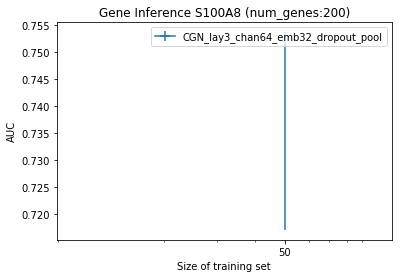

In [52]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 4)
plot_gene = "S100A8"
plot_num_genes = 200

subset = results["df"][(results["df"].num_genes==plot_num_genes) & 
                      (results["df"].gene_name==plot_gene)]

q = subset.groupby(['model','train_size'])['auc']

#for model in ['CGN_2_layer_512_channel_emb_512_dropout', "MLP_2_chan512", "SLR2=lambda10-l1-1"]:#
for model in subset["model"].unique():
    index = q.mean()[model].index
    mean = q.mean()[model]
    stderr = q.std()[model]/np.sqrt(q.count()[model])
    plt.errorbar(index, mean,label=model, xerr=0, yerr=stderr)

plt.title("Gene Inference " + plot_gene + " (num_genes:" + str(plot_num_genes) +")")
plt.ylabel("AUC")
plt.xlabel("Size of training set")
plt.xscale("log")
plt.xticks(index)
formatter = matplotlib.ticker.ScalarFormatter()
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend();

In [90]:
results["df"].model.unique()

array(['CGN_3_layer_64_channel_emb_32_dropout',
       'CGN_2_layer_512_channel_emb_512_dropout', 'MLP_2_chan512-dropout',
       'MLP_2_chan512', 'SLR2=lambda10-l1-1'], dtype=object)

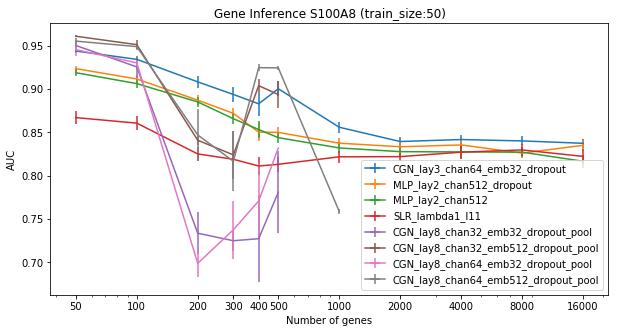

In [27]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
plot_gene = "S100A8"
plot_train_size = 50

subset = results["df"][(results["df"].train_size==plot_train_size) & 
                  (results["df"].gene_name==plot_gene) & 
                  (results["df"].num_genes> 0)]


q = subset.groupby(['model','num_genes'])['auc']

#['CGN_2_layer_512_channel_emb_512_dropout', "MLP_2_chan512", "SLR2=lambda10-l1-1"]:
#for model in ['CGN_2_layer_512_channel_emb_512_dropout', "MLP_2_chan512", "SLR2=lambda10-l1-1"]:
for model in subset["model"].unique():
    index = list(q.mean()[model].index)
    mean = q.mean()[model]
    stderr = q.std()[model]/np.sqrt(q.count()[model])
    plt.errorbar(index, mean,label=model, xerr=0, yerr=stderr)

plt.title("Gene Inference " + plot_gene + " (train_size:" + str(plot_train_size) +")")
plt.ylabel("AUC")
plt.xlabel("Number of genes")
plt.xscale("log")
plt.xticks(sorted(results["df"]["num_genes"].unique()))
formatter = matplotlib.ticker.ScalarFormatter()
plt.gca().xaxis.set_major_formatter(formatter)
#plt.xlim(40,4500)
plt.legend();